# Forecasting bike usage in Berlin
1. EDA
2. Preparing and cleansing data
3. Forecast data

## Import packages and data

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

I read in the data I processed through the `transform_excel.ipynb` notebook and through SQL.

In [3]:
data = pd.read_csv("../data/data_all_years.csv", parse_dates=[0])

## EDA
Nothing special here just some checks on errors, outliers and dimensions. So, I get a better impression of the data.

In [67]:
# Print some samples
data.tail()

,DateTime,station,cyclists
1211302,2017-12-29 06:00:00,schw,12.0
1211303,2017-12-29 06:00:00,yoro,12.0
1211304,2017-12-29 06:00:00,yorw,18.0
1211305,2017-12-29 07:00:00,albe,4.0
1211306,2017-12-29 07:00:00,bern,73.0


In [5]:
# Check data types and data dimensions
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211307 entries, 0 to 1211306
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   DateTime  1211307 non-null  datetime64[ns]
 1   station   1211307 non-null  object        
 2   cyclists  1211307 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 27.7+ MB


In [6]:
# Looking at some statistical measures
data.describe(include='all', datetime_is_numeric=True)

,DateTime,station,cyclists
count,1211307,1211307,1.211307e+06
unique,NaN,26,NaN
top,NaN,schw,NaN
freq,NaN,77466,NaN
mean,2018-04-10 15:15:56.587554048,NaN,9.014837e+01
min,2012-03-01 00:00:00,NaN,-1.000000e+00
25%,2017-01-05 22:00:00,NaN,1.100000e+01
50%,2018-05-06 05:00:00,NaN,4.600000e+01
75%,2019-09-03 13:00:00,NaN,1.270000e+02
max,2020-12-31 23:00:00,NaN,2.167000e+03


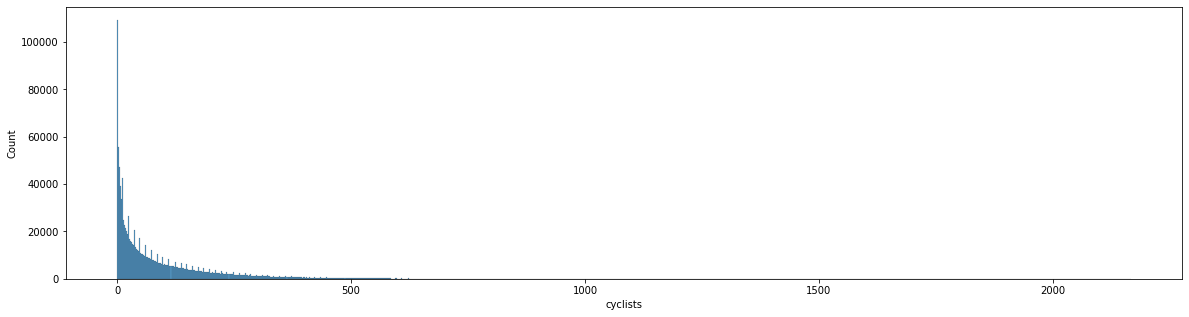

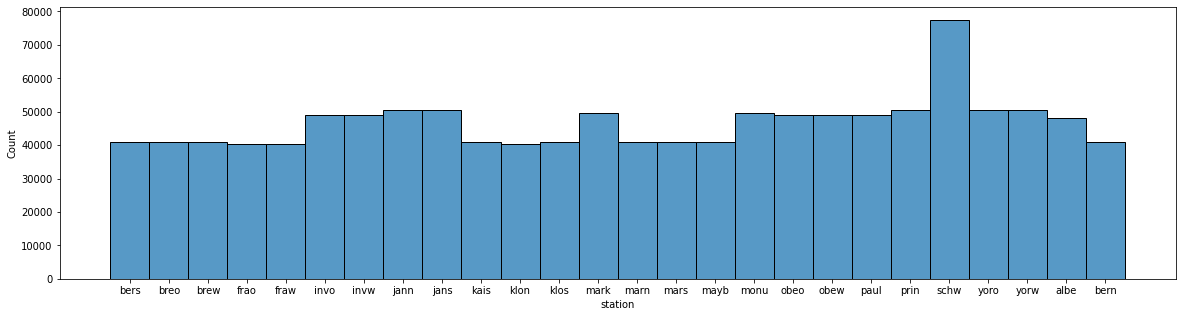

<AxesSubplot:xlabel='DateTime', ylabel='Count'>

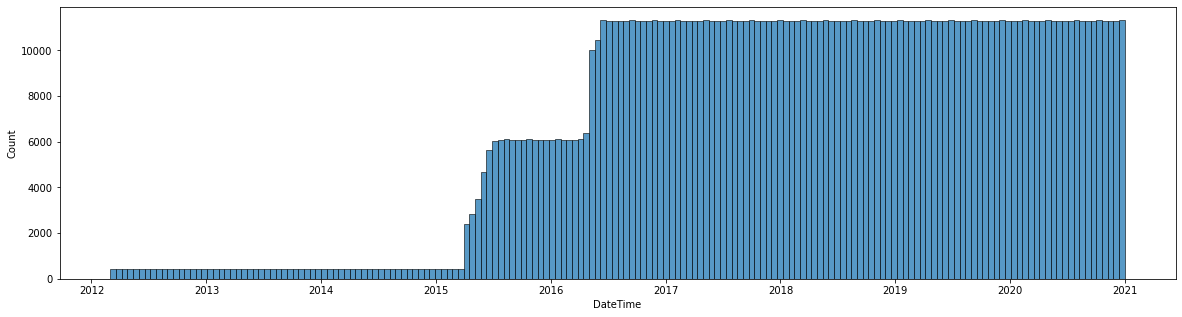

In [7]:
# Look at the distribution of data
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='cyclists')
plt.show()
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='station')
plt.show()
plt.figure(figsize=(20,5))
sns.histplot(data=data, x='DateTime')

### Missing values
check for missing values. There should be no missing values as I filtered them out in SQL. 

In [8]:
data.isna().sum()


DateTime    0
station     0
cyclists    0
dtype: int64

### Errors
In contrast of missing values, there are many error values. I delete them so that I can see how many usabel data I have for each station.

<AxesSubplot:xlabel='count', ylabel='station'>

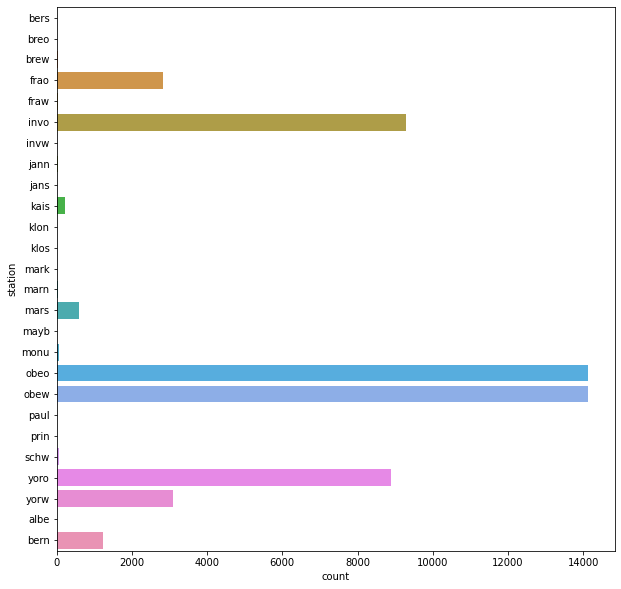

In [9]:
# counting values for each station
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[(data['station'] == i) & (data['cyclists'] == -1)].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

#### Cleaning errors

In [10]:
data_clean = data
data_clean.loc[data.cyclists == -1, 'cyclists'] = np.nan
data_clean.dropna(inplace=True)
data_clean.shape[0]

1156547

### Outliers
As you can see in the box plot below, there are some outliers. But because I will sum the hourly data up to daily measurements I won't clean them now. 

<AxesSubplot:xlabel='station', ylabel='cyclists'>

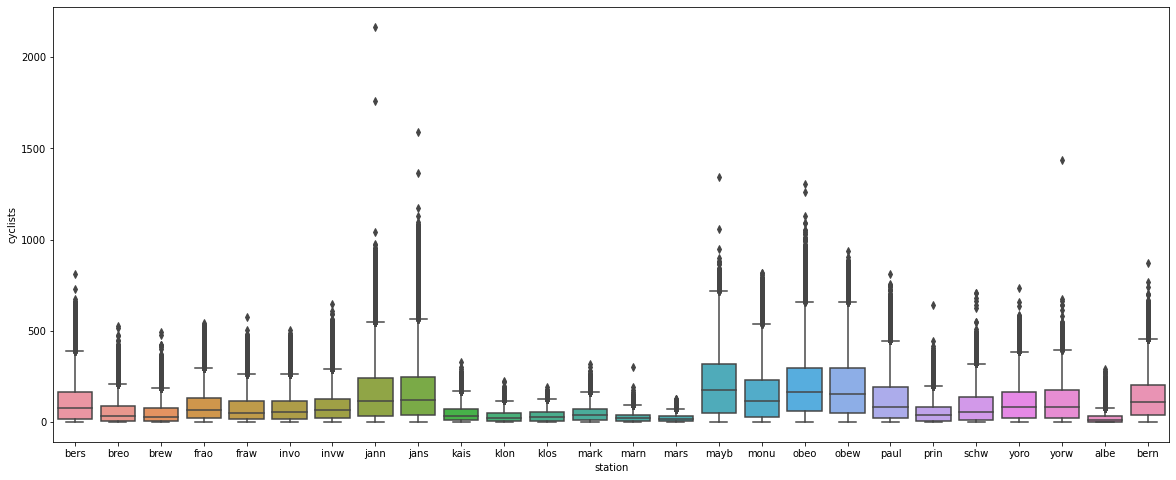

In [11]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data, y='cyclists', x="station")

<AxesSubplot:xlabel='count', ylabel='station'>

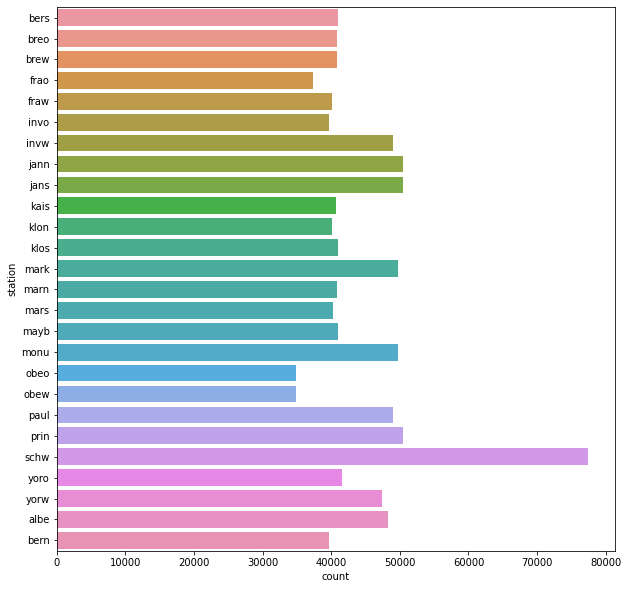

In [12]:
# counting usable values for each station
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

## Prepare the data
I augment the records by calculated information  
- weekend
- bank holiday
- winter or summer

I will handle the forecasting challenge as a regression task. Therefore, I will split the date in its components.  
As I want to have the prediction on a daily level, I will group all data per day by sum.

In [13]:
data_augmented = data_clean.copy()
weekend_list = []
for row_weekday in data_augmented['DateTime']:
    if row_weekday.weekday() >= 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)
data_augmented['weekend'] = weekend_list

In [14]:
summer_list = [1 if date.month >= 3 and date.month <= 10 else 0 for date in data_augmented['DateTime']]
data_augmented['summer'] = summer_list

In [15]:
data_augmented.head()

,DateTime,station,cyclists,weekend,summer
0,2017-12-29 07:00:00,bers,32.0,0,0
1,2017-12-29 07:00:00,breo,18.0,0,0
2,2017-12-29 07:00:00,brew,14.0,0,0
3,2017-12-29 07:00:00,frao,14.0,0,0
4,2017-12-29 07:00:00,fraw,16.0,0,0


In [16]:
import requests

url = "https://feiertage-api.de/api/?nur_land=BE&jahr="
response = []

for year in range(2012, 2021):
    year_response = requests.request("GET", url+str(year)).json()
    for holiday in year_response:
        response.append(year_response[holiday]["datum"])

print(response)

['2012-01-01', '2012-04-06', '2012-04-09', '2012-05-01', '2012-05-17', '2012-05-28', '2012-10-03', '2012-12-25', '2012-12-26', '2013-01-01', '2013-03-29', '2013-04-01', '2013-05-01', '2013-05-09', '2013-05-20', '2013-10-03', '2013-12-25', '2013-12-26', '2014-01-01', '2014-04-18', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-10-03', '2014-12-25', '2014-12-26', '2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-10-03', '2015-12-25', '2015-12-26', '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03', '2017-10-31', '2017-12-25', '2017-12-26', '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-01', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-25', '2018-12-26', '2019-01-01', '2019-03-08', '2019-04-19', '2019-04-22', '2019-05-01', '2019-05-30', '2019-06-10', '2019

In [17]:
data_augmented['bank_holiday'] = [1 if str(date.date()) in response else 0 for date in data_augmented["DateTime"]]

In [18]:
data_mean = data_augmented.copy()
data_mean["Day"] = data_mean["DateTime"].dt.day
data_mean["Month"] = data_mean["DateTime"].dt.month
data_mean["Year"] = data_mean["DateTime"].dt.year
data_mean["min"] = data_mean["DateTime"].dt.hour
data_mean.drop("DateTime", axis=1, inplace=True)

get_first = lambda col: col.head(1)

data_mean = data_mean\
    .groupby(by=["Year", "Month", "Day", "station"], as_index=False)\
    .agg({'cyclists': 'sum', 'bank_holiday': get_first, 'weekend': get_first, 'summer': get_first})


In [19]:
data_mean.shape

(48232, 8)

### Revisit the outliers
We check again for outliers. There are only a few and removing them would effect only a small performance increase.

<AxesSubplot:xlabel='station', ylabel='cyclists'>

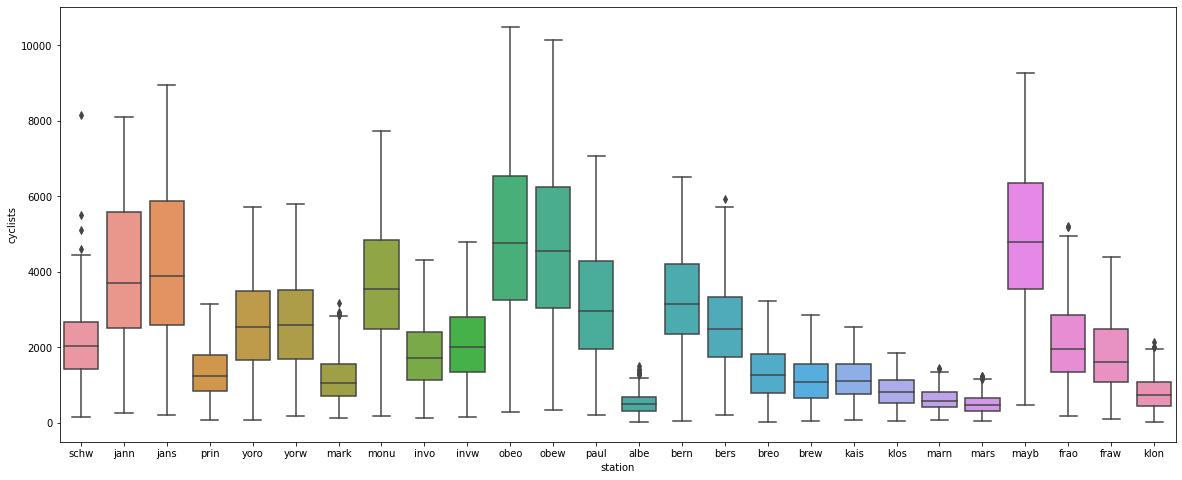

In [20]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data_mean, y='cyclists', x="station")

## Develop Forecasting Model
### Regression Model

I will train a model for every station. So, I don't have to encode the station name and I can leave this column out.  
This example will be with station `schw`. 

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import datetime


In [59]:
station = "schw"

train_X = data_mean.loc[data_mean["station"] == station,["Year", "Month", "Day", "bank_holiday", "weekend", "summer"]]
train_X = train_X.iloc[:int(train_X.shape[0]*0.9)]
train_y = data_mean.loc[data_mean["station"] == station,["cyclists"]]
train_y = train_y.iloc[:int(train_y.shape[0]*0.9)]

print(train_X.shape[0])
print(train_y.shape[0])

test_X = data_mean.loc[data_mean["station"] == station,["Year", "Month", "Day", "bank_holiday", "weekend", "summer"]]
test_X = train_X.iloc[int(train_X.shape[0]*0.9):]
test_y = data_mean.loc[data_mean["station"] == station,["cyclists"]]
test_y = train_y.iloc[int(train_y.shape[0]*0.9):]

print(test_X.shape[0])
print(test_y.shape[0])

2903
2903
291
291


In [23]:
param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
                'n_estimators':[100,250,500,750,1000,1250,1500,1750],
                'max_depth':[2,3,4,5,6,7],
                'min_samples_split':[2,4,6,8,10,20,40,60,100], 
                'min_samples_leaf':[1,3,5,7,9],
                'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
    }
clf = RandomizedSearchCV(GradientBoostingRegressor(random_state=123), n_iter=20, n_jobs=-1, param_distributions=param_grid, scoring='neg_mean_squared_error', verbose=0, random_state=123)
clf.fit(train_X, train_y)
print(clf.best_params_)


C:\Users\Philip Singer\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'subsample': 0.85, 'n_estimators': 1250, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.005}


In [60]:
gbr = GradientBoostingRegressor(
    random_state=123, 
    subsample=0.85,
    n_estimators=1250,
    min_samples_split=8,
    min_samples_leaf=1, 
    max_depth=3,
    learning_rate=0.005,
)

gbr.fit(train_X, train_y)
pred_y = pd.DataFrame(gbr.predict(test_X))

def validate(test_y, pred_y):
    print("MSE", metrics.mean_squared_error(test_y, pred_y))
    print("RMSE", metrics.mean_squared_error(test_y, pred_y, squared=False))
    print("R2", metrics.r2_score(test_y, pred_y))
    print("MAPE", metrics.mean_absolute_percentage_error(test_y, pred_y))
    
validate(test_y, pred_y)

C:\Users\Philip Singer\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE 224316.84019428305
RMSE 473.6209879157416
R2 0.6096347478631594
MAPE 0.2355567538196684


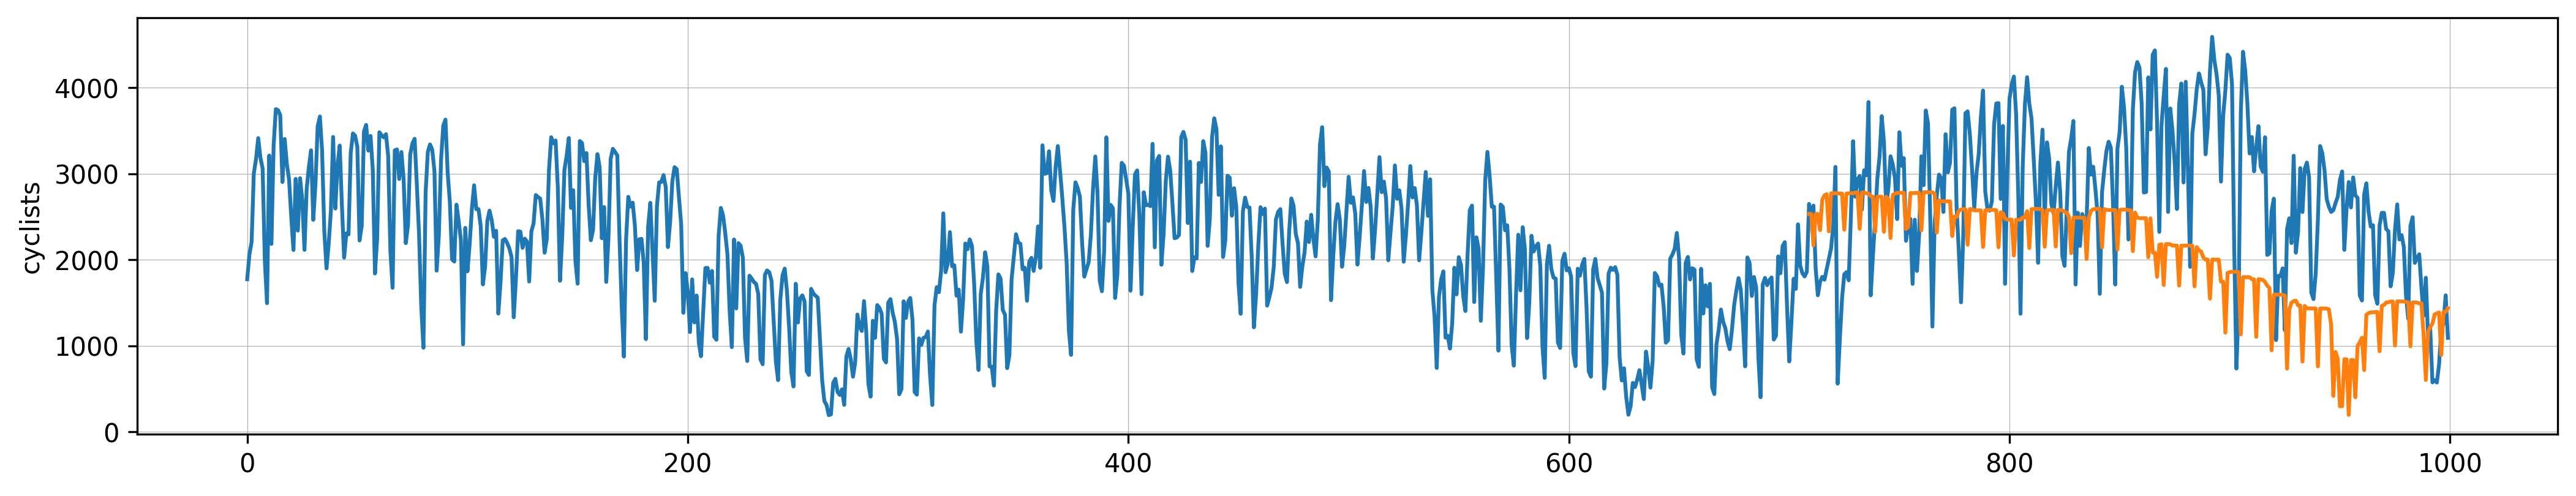

In [83]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
g = sns.lineplot(data=data_mean.loc[data_mean["station"] == station].tail(1000), y = 'cyclists', x=np.arange((data_mean.loc[data_mean["station"] == station].tail(1000).shape[0])))
sns.lineplot(data=pred_y, x=np.arange((1000-291), 1000), y=0)
plt.grid(linestyle='-', linewidth=0.3)

I find the MAPE metric is the most usabele one because the real numbers are too big to evaluate the performance of the model. But also 24% mean error are not very good.  And you can see, that the model predict not high enough values and decreases the prediction too early.  

### Prophet Model
I want to try the Prophet API developed by Facebook (https://facebook.github.io/prophet/docs/quick_start.html). This is a "real" time-series/forecasting model, but it follows the API style of sklearn, so it's easier for me, as I am familiar with this API style.